In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_original = pd.read_csv('good_samples_cleaned.csv')
df = df_original.copy()

df.head(5)

,LogName,Date,Time,ComputerName,SourceName,TaskCategory,EventType,Keywords,OpCode,EventCode,Type,RecordNumber,Message
0,Application,2023-09-22,00:10:15,CLIENT-PC,Microsoft-Windows-Security-SPP,NaN,4,Classic,NaN,16384,4,3267,Successfully scheduled Software Protection ser...
1,System,2023-09-22,00:10:01,CLIENT-PC,Microsoft-Windows-Kernel-General,NaN,4,NaN,Info,16,4,2279,The access history in hive \??\C:\Users\Commun...
2,Application,2023-09-22,00:09:45,CLIENT-PC,SecurityCenter,NaN,4,Classic,Info,15,4,3266,Updated Windows Defender status successfully t...
3,System,2023-09-22,00:09:23,CLIENT-PC,Microsoft-Windows-Kernel-General,NaN,4,NaN,Info,16,4,2278,The access history in hive \??\C:\Users\Commun...
4,Application,2023-09-22,00:09:20,CLIENT-PC,Microsoft-Windows-Security-SPP,NaN,2,Classic,NaN,8198,2,3265,License Activation (slui.exe) failed with the ...


### Pre-proccessing for Isolation Forest Model

In order for the IsolationForest algorithm to work, we need to convert all the features to a numeric values:

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S', errors='coerce')
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Second'] = df['Time'].dt.second

df.drop(['Date','Time'], axis=1, inplace=True)

In [4]:
# Initialize a LabelEncoder
label_encoder = LabelEncoder()

df['LogName'] = label_encoder.fit_transform(df['LogName'])
df['Keywords'] = label_encoder.fit_transform(df['Keywords'])
df['TaskCategory'] = label_encoder.fit_transform(df['TaskCategory'])
df['SourceName'] = label_encoder.fit_transform(df['SourceName'])
df['OpCode'] = label_encoder.fit_transform(df['OpCode'])
df['ComputerName'] = label_encoder.fit_transform(df['OpCode'])

Vectorizing the Message feature:

In [5]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=1000, stop_words='english')

# Fit and transform the 'Message' column
message_bow = vectorizer.fit_transform(df['Message'])

# Convert the bag of words representation to a DataFrame
message_df = pd.DataFrame(message_bow.toarray(), columns=vectorizer.get_feature_names_out())

# Add the BoW representation as new columns in your original DataFrame
df = pd.concat([df, message_df], axis=1)

df.drop(['Message'], axis=1, inplace=True)

Let's see how our dataset looks now:

In [6]:
df.tail(5)

,LogName,ComputerName,SourceName,TaskCategory,EventType,Keywords,OpCode,EventCode,Type,RecordNumber,...,wsearch,x64,xboxapp_8wekyb3d8bbwe,xboxgamingoverlay_8wekyb3d8bbwe,xboxidentityprovider_8wekyb3d8bbwe,yourphone_8wekyb3d8bbwe,zone,zunemusic_11,zunemusic_8wekyb3d8bbwe,zunevideo_8wekyb3d8bbwe
346,3,1,13,10,4,6,1,27,4,2131,...,0,0,0,0,0,0,0,0,0,0
347,3,1,13,9,4,6,1,25,4,2130,...,0,0,0,0,0,0,0,0,0,0
348,3,1,13,8,4,6,1,20,4,2129,...,0,0,0,0,0,0,0,0,0,0
349,3,1,13,15,4,6,1,153,4,2128,...,0,0,0,0,0,0,0,0,0,0
350,3,1,14,0,4,6,1,12,4,2127,...,0,0,0,0,0,0,0,0,0,0


Now, let's execute the IsolationForest algorithm on our dataset:

In [7]:
X = df

# Create and train the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)
model.fit(X)

IsolationForest(contamination=0.05, random_state=42)

Let's predict using the model we built:

In [8]:
# Predict anomaly scores for each data point
anomaly_scores = model.decision_function(X)

# Add the anomaly scores as a new column
df_original['AnomalyScore'] = anomaly_scores

Let's check the results:

In [9]:
# Identify anomalies based on a threshold
anomalies = df_original[df_original['AnomalyScore'] > 0.06]

anomalies.tail(5)

,LogName,Date,Time,ComputerName,SourceName,TaskCategory,EventType,Keywords,OpCode,EventCode,Type,RecordNumber,Message,AnomalyScore
239,Application,2023-09-21,23:19:22,CLIENT-PC,SecurityCenter,NaN,4,Classic,Info,1,4,3140,The Windows Security Center Service has started.,0.062497
259,Application,2023-09-21,23:17:09,CLIENT-PC,Microsoft-Windows-Search,Search service,4,Classic,NOTE: This dummy error message is necessary t...,1003,4,3131,The Windows Search Service started.,0.066077
265,Application,2023-09-21,23:17:07,CLIENT-PC,edgeupdate,NaN,4,Classic,Info,0,4,3125,Service stopped.,0.061490
289,Application,2023-09-21,23:14:58,CLIENT-PC,Microsoft-Windows-Security-SPP,NaN,4,Classic,NaN,1066,4,3110,Initialization status for service objects.\r,0.061187
311,Application,2023-09-21,23:14:37,CLIENT-PC,Microsoft-Windows-User Profile Service,NaN,4,NaN,Info,1531,4,3104,The User Profile Service has started successfu...,0.062454


### Model Evaluation:

Let's see the distribution of the anomaly scores:

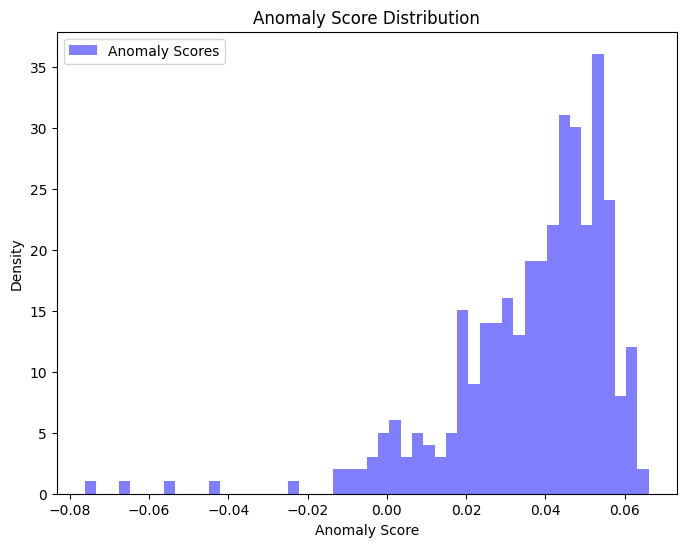

In [10]:
# Plot the anomaly score distribution
plt.figure(figsize=(8, 6))
plt.hist(anomaly_scores, bins=50, density=True, alpha=0.5, color='blue', label='Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.title('Anomaly Score Distribution')
plt.legend()
plt.show()

We can see that there are not many anomalies, which usually gets a score under 0.

Let's assume that we have 5% anomalies in our dataset.<br>
Now let's check what feature vectors are going to be considered anomalies:

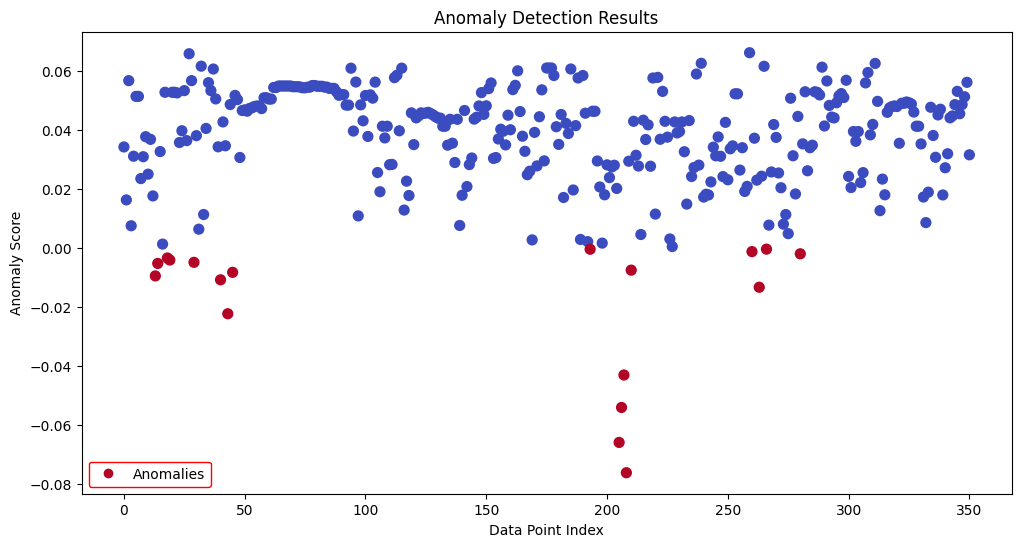

Number of anomalies detected: 18


In [11]:
# Determine a threshold based on percentiles
threshold = np.percentile(anomaly_scores, 5)  # 5th percentile as an example

# Identify anomalies based on the threshold
anomaly_mask = (anomaly_scores < threshold)

# Plot the data points and highlight anomalies in red
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df.index, df_original['AnomalyScore'], c=anomaly_mask, cmap='coolwarm', s=50)
plt.xlabel('Data Point Index')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection Results')
plt.legend(handles=[scatter.legend_elements()[0][1]], labels=['Anomalies'], loc='lower left', facecolor='white', framealpha=1, edgecolor='red')
plt.show()

# Count the number of anomalies detected
num_anomalies_detected = np.sum(anomaly_mask)
print(f'Number of anomalies detected: {num_anomalies_detected}')


As we can see, there are 4 definite anomalies at the bottom, and by adjusting the threshold we can tune the algorithm to be more precise.

#### <u>Note:</u>
This time, there's no need to save the model since it should work as-is on a new dataset. Our main focus should be on preprocessing the dataset and replacing all non-numeric values with numeric values.